# Typosquat, IDN & Combosquat Detector

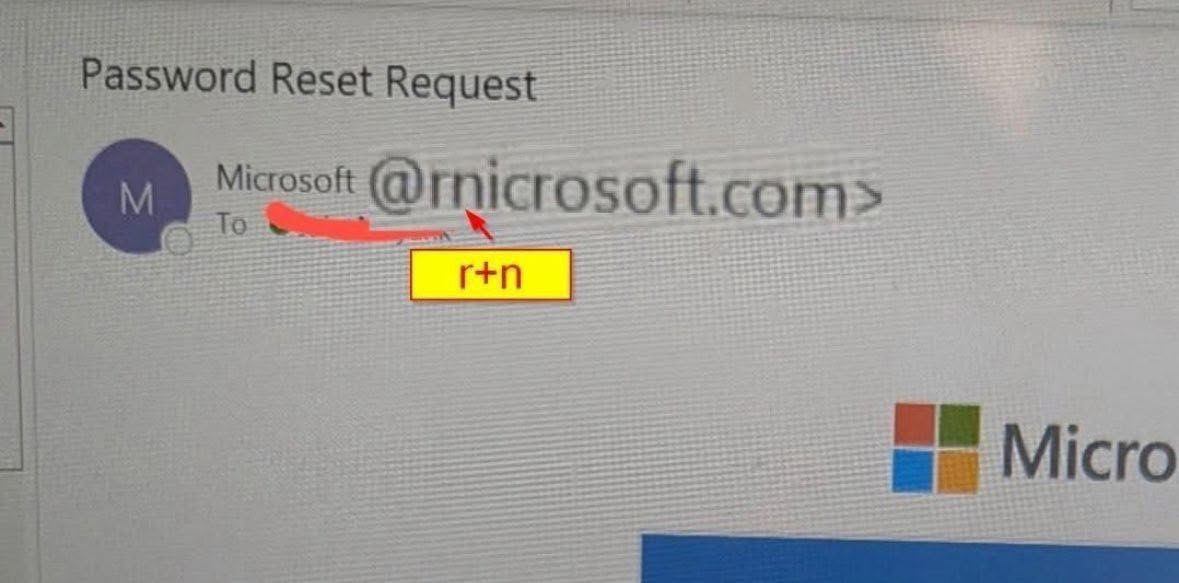

In [1]:
%pip -q install rapidfuzz tldextract idna confusable-homoglyphs regex pandas
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
import regex as regx
print("regex OK:", regx.__version__)

import unicodedata as ud
for s in ["аpple", "раypal"]:
    print(s, [f"{c} {hex(ord(c))} {ud.name(c, '?')}" for c in s])


regex OK: 2.5.148
аpple ['а 0x430 CYRILLIC SMALL LETTER A', 'p 0x70 LATIN SMALL LETTER P', 'p 0x70 LATIN SMALL LETTER P', 'l 0x6c LATIN SMALL LETTER L', 'e 0x65 LATIN SMALL LETTER E']
раypal ['р 0x440 CYRILLIC SMALL LETTER ER', 'а 0x430 CYRILLIC SMALL LETTER A', 'y 0x79 LATIN SMALL LETTER Y', 'p 0x70 LATIN SMALL LETTER P', 'a 0x61 LATIN SMALL LETTER A', 'l 0x6c LATIN SMALL LETTER L']


## Imports and constants

In [3]:
from __future__ import annotations
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple, Iterable, Set
import unicodedata, re, csv, os, json
import pandas as pd
import tldextract
import idna
from rapidfuzz.distance import Levenshtein as Lev
from rapidfuzz.distance import DamerauLevenshtein as DLev
from rapidfuzz import process as rf_process

try:
    import regex as regx
    HAS_REGEX = True
except Exception:
    HAS_REGEX = False

try:
    from confusable_homoglyphs import confusables as ch_conf
    HAS_CONFUSABLE = True
except Exception:
    HAS_CONFUSABLE = False

_TLD_EXTRACT = tldextract.TLDExtract(suffix_list_urls=None)

COMBO_KEYWORDS = {
    "support", "help", "secure", "security", "login", "signin", "verify", "update",
    "service", "account", "pay", "payment", "invoice", "billing", "wallet", "reset",
    "auth", "activate", "unlock", "portal", "access",
    "alert", "notice", "verify-identity", "account-update", "passcode", "otp",
    "recover", "recovery", "download", "install", "claim", "refund"
}

def _norm(s: str) -> str:
    return unicodedata.normalize("NFC", s).lower()

def idna_to_unicode(domain: str) -> str:
    out = []
    for label in domain.split("."):
        try:
            out.append(idna.decode(label.encode("ascii")))
        except Exception:
            out.append(label)
    return ".".join(out)

def unicode_to_idna(domain: str) -> str:
    out = []
    for label in domain.split("."):
        try:
            out.append(idna.encode(label).decode("ascii"))
        except Exception:
            try:
                out.append(label.encode("idna").decode("ascii"))
            except Exception:
                out.append(label)
    return ".".join(out)

def parse_domain(host: str) -> Dict[str, str]:
    host = host.strip().strip(".").split("/")[0]
    ext = _TLD_EXTRACT(host)
    return {
        "subdomain": ext.subdomain or "",
        "sld": ext.domain or "",
        "tld": ext.suffix or "",
        "etld1": ext.registered_domain or "",
        "host": host
    }

def script_profile(s: str) -> Dict[str, object]:
    scripts = {}
    if HAS_REGEX:
        for name in ["Latin", "Cyrillic", "Greek", "Common", "Inherited", "Arabic", "Hebrew"]:
            pat = regx.compile(r"\p{Script=" + name + r"}")
            count = len(pat.findall(s))
            if count:
                scripts[name] = count
    else:
        for ch in s:
            try:
                name = unicodedata.name(ch)
            except ValueError:
                continue
            for tag in ("LATIN", "CYRILLIC", "GREEK", "ARABIC", "HEBREW", "COMMON", "INHERITED"):
                if tag in name:
                    key = tag.title()
                    scripts[key] = scripts.get(key, 0) + 1
                    break
    total = sum(scripts.values()) if scripts else 0
    mixed = len([k for k in scripts if k not in ("Common", "Inherited")]) > 1
    return {"scripts": scripts, "total_chars_classified": total, "mixed_scripts": mixed}

def confusable_summary(s: str, preferred_aliases: Optional[List[str]] = None) -> Dict[str, object]:
    preferred_aliases = preferred_aliases or ["latin", "common"]
    is_confusable = False
    is_mixed = False
    details = []
    dangerous = False
    if HAS_CONFUSABLE:
        res = ch_conf.is_confusable(s, greedy=True, preferred_aliases=preferred_aliases)
        if res:
            is_confusable = True
            details = res if isinstance(res, list) else [res]
        is_mixed = bool(ch_conf.is_mixed_script(s))
        dangerous = bool(ch_conf.is_dangerous(s, preferred_aliases=preferred_aliases))
    else:
        prof = script_profile(s)
        is_mixed = prof["mixed_scripts"]
        dangerous = is_mixed
    return {
        "is_confusable": is_confusable,
        "is_mixed_script": is_mixed,
        "is_dangerous_mixed": dangerous,
        "confusable_detail": details,
        "confusable_count": len(details)
    }

_SPLIT = re.compile(r"[^a-z0-9]+")
def tokens(s: str) -> List[str]:
    return [t for t in _SPLIT.split(_norm(s)) if t]


## Brand index, distances, combosquat features

In [4]:
def lev_metrics(a: str, b: str) -> Dict[str, float]:
    a = _norm(a); b = _norm(b)
    d = Lev.distance(a, b)
    dn = d / max(1, max(len(a), len(b)))
    dl = DLev.distance(a, b)
    dln = dl / max(1, max(len(a), len(b)))
    return {"lev_distance": float(d), "lev_norm": float(dn), "dlev_distance": float(dl), "dlev_norm": float(dln)}

@dataclass
class BrandIndex:
    brands: List[str]
    brand_tokens: List[str]

    @classmethod
    def from_brands(cls, brands: Iterable[str]) -> "BrandIndex":
        bl = [_norm(b) for b in brands]
        bt = [re.sub(r"[^a-z0-9]", "", b) for b in bl]
        return cls(bl, bt)

    def nearest_brand(self, label: str, scorer: str = "lev") -> Tuple[str, float]:
        query = _norm(label)
        if not self.brands:
            return ("", 0.0)
        rf_scorer = Lev.normalized_similarity if scorer == "lev" else DLev.normalized_similarity
        match = rf_process.extractOne(query, self.brands, scorer=rf_scorer, score_cutoff=0.6)
        if match is None:
            match = rf_process.extractOne(query, self.brands, scorer=rf_scorer)
        return (match[0], float(match[1])) if match else ("", 0.0)

def contains_brand_token(label: str, brand: str) -> bool:
    lab = re.sub(r"[^a-z0-9]", "", _norm(label))
    br = re.sub(r"[^a-z0-9]", "", _norm(brand))
    return br in lab and len(br) >= 3

def combosquat_features(label: str, brands: List[str]) -> Dict[str, object]:
    toks = tokens(label)
    keywords = sorted({t for t in toks if t in COMBO_KEYWORDS})
    brand_tokens_found = sorted({b for b in brands if contains_brand_token(label, b)})
    return {
        "has_brand_token": len(brand_tokens_found) > 0,
        "brand_tokens_found": brand_tokens_found,
        "combo_keywords": keywords,
        "combo_keyword_count": len(keywords)
    }


## Umbrella Top‑1M loader

In [5]:
def _etld1(host: str) -> str:
    ext = _TLD_EXTRACT(host.strip().strip("."))
    return ext.registered_domain or host

def load_umbrella_csv(path: str, use_chunks: bool = False, chunksize: int = 200_000, domain_col: Optional[str] = None) -> Tuple[Set[str], Set[str]]:
    full_hosts: Set[str] = set()
    etld1s: Set[str] = set()
    if not use_chunks:
        with open(path, newline="", encoding="utf-8") as f:
            try:
                sniffer = csv.Sniffer(); sample = f.read(2048); f.seek(0)
                has_header = sniffer.has_header(sample)
            except Exception:
                has_header = False
            if has_header:
                rdr = csv.DictReader(f)
                key = domain_col or next((k for k in rdr.fieldnames or [] if "domain" in k.lower()), None)
                if not key:
                    cand = [k for k in rdr.fieldnames or [] if "rank" not in k.lower()]
                    key = cand[0] if cand else (rdr.fieldnames[0] if rdr.fieldnames else None)
                for row in rdr:
                    d = (row.get(key) or "").strip()
                    if not d: continue
                    full_hosts.add(d); etld1s.add(_etld1(d))
            else:
                rdr = csv.reader(f)
                for row in rdr:
                    if not row: continue
                    d = (row[1].strip() if len(row) > 1 else row[0].split(",")[-1].strip())
                    if not d: continue
                    full_hosts.add(d); etld1s.add(_etld1(d))
    else:
        reader = pd.read_csv(path, chunksize=chunksize, dtype=str, header="infer", on_bad_lines="skip")
        for chunk in reader:
            cols = list(chunk.columns)
            key = domain_col or next((c for c in cols if c.lower() == "domain"), None) or cols[-1]
            series = chunk[key].astype(str).str.strip()
            for d in series:
                if not d or d.lower() == "domain": continue
                full_hosts.add(d); etld1s.add(_etld1(d))
    return full_hosts, etld1s


## Scoring and flattening

In [6]:
def _etld1(host: str) -> str:
    ext = _TLD_EXTRACT(host.strip().strip("."))
    return ext.registered_domain or host

def load_umbrella_csv(path: str, use_chunks: bool = False, chunksize: int = 200_000, domain_col: Optional[str] = None) -> Tuple[Set[str], Set[str]]:
    full_hosts: Set[str] = set()
    etld1s: Set[str] = set()
    if not use_chunks:
        with open(path, newline="", encoding="utf-8") as f:
            try:
                sniffer = csv.Sniffer(); sample = f.read(2048); f.seek(0)
                has_header = sniffer.has_header(sample)
            except Exception:
                has_header = False
            if has_header:
                rdr = csv.DictReader(f)
                key = domain_col or next((k for k in rdr.fieldnames or [] if "domain" in k.lower()), None)
                if not key:
                    cand = [k for k in rdr.fieldnames or [] if "rank" not in k.lower()]
                    key = cand[0] if cand else (rdr.fieldnames[0] if rdr.fieldnames else None)
                for row in rdr:
                    d = (row.get(key) or "").strip()
                    if not d: continue
                    full_hosts.add(d); etld1s.add(_etld1(d))
            else:
                rdr = csv.reader(f)
                for row in rdr:
                    if not row: continue
                    d = (row[1].strip() if len(row) > 1 else row[0].split(",")[-1].strip())
                    if not d: continue
                    full_hosts.add(d); etld1s.add(_etld1(d))
    else:
        reader = pd.read_csv(path, chunksize=chunksize, dtype=str, header="infer", on_bad_lines="skip")
        for chunk in reader:
            cols = list(chunk.columns)
            key = domain_col or next((c for c in cols if c.lower() == "domain"), None) or cols[-1]
            series = chunk[key].astype(str).str.strip()
            for d in series:
                if not d or d.lower() == "domain": continue
                full_hosts.add(d); etld1s.add(_etld1(d))
    return full_hosts, etld1s

def score_domain(domain: str, brand_index: BrandIndex, prefer_scripts: Optional[List[str]] = None) -> Dict[str, object]:
    raw = domain.strip().lower()
    uni = idna_to_unicode(raw)
    ace = unicode_to_idna(uni)
    parsed = parse_domain(uni)
    etld1 = parsed["etld1"]
    sld = parsed["sld"]

    is_idn = any(lbl.startswith("xn--") for lbl in ace.split("."))
    scripts = script_profile(sld)
    conf = confusable_summary(sld, preferred_aliases=prefer_scripts or ["latin", "common"])

    best_brand, sim01 = brand_index.nearest_brand(sld, scorer="lev")
    sim = float(sim01)

    metrics = lev_metrics(sld, best_brand) if best_brand else {
        "lev_distance": 0.0, "lev_norm": 0.0, "dlev_distance": 0.0, "dlev_norm": 0.0
    }

    combo = combosquat_features(etld1 or sld, brand_index.brands)

    risk = 0.0
    if metrics["dlev_distance"] <= 2 or sim >= 0.8:
        risk += 3.0
    if conf["is_dangerous_mixed"] or conf["is_confusable"]:
        risk += 3.0
    if combo["has_brand_token"]:
        risk += 2.0
    if combo["combo_keyword_count"] > 0:
        risk += 1.5
    if is_idn and (metrics["dlev_distance"] <= 2 or combo["has_brand_token"]):
        risk += 1.5

    if (sld == best_brand) and not conf["is_confusable"] and not scripts["mixed_scripts"]:
        risk = 0.0

    return {
        "input": raw,
        "unicode_domain": uni,
        "ace_domain": ace,
        "parsed": parsed,
        "is_idn": is_idn,
        "script_profile": scripts,
        "confusable": conf,
        "best_brand": best_brand,
        "brand_similarity_pct": round(sim * 100.0, 2),
        "brand_similarity": round(sim, 4),
        "edit_metrics": metrics,
        "combosquat": combo,
        "risk_score": round(risk, 2),
    }

def flatten_result(res: Dict[str, object]) -> Dict[str, object]:
    out = {
        "input": res["input"],
        "unicode_domain": res["unicode_domain"],
        "ace_domain": res["ace_domain"],
        "is_idn": res["is_idn"],
        "best_brand": res["best_brand"],
        "brand_similarity_pct": res["brand_similarity_pct"],
        "brand_similarity": res["brand_similarity"],
        "risk_score": res["risk_score"],
    }

    p = res.get("parsed", {}) or {}
    out.update({
        "parsed_subdomain": p.get("subdomain"),
        "parsed_sld": p.get("sld"),
        "parsed_tld": p.get("tld"),
        "parsed_etld1": p.get("etld1"),
        "parsed_host": p.get("host"),
    })

    sp = res.get("script_profile", {}) or {}
    sp_scripts = sp.get("scripts") if isinstance(sp.get("scripts"), dict) else {}
    out.update({
        "script_total_chars": sp.get("total_chars_classified"),
        "script_mixed": sp.get("mixed_scripts"),
        "script_Latin": sp_scripts.get("Latin", 0),
        "script_Cyrillic": sp_scripts.get("Cyrillic", 0),
        "script_Greek": sp_scripts.get("Greek", 0),
        "script_Arabic": sp_scripts.get("Arabic", 0),
        "script_Hebrew": sp_scripts.get("Hebrew", 0),
        "script_Common": sp_scripts.get("Common", 0),
        "script_Inherited": sp_scripts.get("Inherited", 0),
    })

    cf = res.get("confusable", {}) or {}
    out.update({
        "conf_is_confusable": cf.get("is_confusable"),
        "conf_is_mixed_script": cf.get("is_mixed_script"),
        "conf_is_dangerous_mixed": cf.get("is_dangerous_mixed"),
        "conf_confusable_count": cf.get("confusable_count"),
        "conf_confusable_detail": json.dumps(cf.get("confusable_detail", []), ensure_ascii=False),
    })

    em = res.get("edit_metrics", {}) or {}
    out.update({
        "lev_distance": em.get("lev_distance"),
        "lev_norm": em.get("lev_norm"),
        "dlev_distance": em.get("dlev_distance"),
        "dlev_norm": em.get("dlev_norm"),
    })

    cq = res.get("combosquat", {}) or {}
    ck = cq.get("combo_keywords", []) or []
    out.update({
        "combo_has_brand_token": cq.get("has_brand_token"),
        "combo_brand_tokens_found": ",".join(cq.get("brand_tokens_found", [])) if cq.get("brand_tokens_found") else "",
        "combo_keyword_count": cq.get("combo_keyword_count"),
        "combo_keywords": ",".join(ck) if ck else "",
    })

    if "umbrella_common" in res:
        out["umbrella_common"] = res["umbrella_common"]
    return out


## Configuration

In [7]:
umbrella_path = "top-1m.csv"
umbrella_chunks = True
output_path = "scores.csv"

domains = [
   "micr0soft.com",              # Typosquat: zero instead of o
   "amazoon.com",                # Typosquat: double 'o'
   "https://www.microsoft.com/terms", # Legit legitimate URL with path
   "calender.google.com",        # Typosquat: misspelled calendar
   "gooogle.com",                # Typosquat: extra 'o'
   "faceb00k.com",               # Typosquat: zeros instead of o
   "micros0ft-support.com",      # Combosquat: substitution + token
   "amazon-authentication.com",  # Combosquat: added token
   "calendar-google.account.com",# Combosquat: adds token + changes order
   "аррӏе.com",                  # Homoglyph: Cyrillic characters instead of apple
   "gооgle.com",                 # Homoglyph: Cyrillic о for o
   "amazоn.com",                 # Homoglyph: Cyrillic о for o
   "rnicrosoft.com",             # Homoglyph: r + n instead of m
   "іnvіϲtі.com",                # Homoglyph: Cyrillic mixed in invicti
   "xn--microsft-9ya.com",       # IDN punycode variant of microsoft
   "xn--goog1e-65d.com",         # IDN punycode variant of google1
   "рaypal.com",                 # Cyrillic р for p (paypal)
   "уahoo.com",                  # Cyrillic у for y (yahoo)
   "bankofамerica.com"           # Cyrillic а, м mixed in bankofamerica
]


## Run scoring and export CSV (all metrics flattened into columns)

In [8]:
try:
    import regex as _regx  # ensure installed
except Exception:
    print("Note: install 'regex' for Unicode script profiling (pip install regex)")
brands = ["google", "microsoft", "paypal", "apple", "amazon", "facebook"]
bidx = BrandIndex.from_brands(brands)

is_full_common = lambda h: False
is_etld1_common = lambda h: False
if umbrella_path and os.path.exists(umbrella_path):
    full, etlds = load_umbrella_csv(umbrella_path, use_chunks=umbrella_chunks, chunksize=200_000)
    is_full_common = lambda h, _full=full: h in _full
    is_etld1_common = lambda h, _etlds=etlds: _etld1(h) in _etlds
else:
    print(f"Umbrella file not found at {umbrella_path}; continuing without popularity prefilter")

results = []
for d in domains:
    res = score_domain(d, bidx)
    common = is_full_common(d) or is_etld1_common(d)
    res["umbrella_common"] = bool(common)
    if common:
        if res["parsed"]["sld"] == res["best_brand"]:
            res["risk_score"] = 0.0
        else:
            res["risk_score"] = max(0.0, float(res["risk_score"]) - 2.0)
    results.append(res)

flat_rows = [flatten_result(r) for r in results]
df = pd.DataFrame(flat_rows).sort_values(["risk_score", "brand_similarity_pct"], ascending=[False, False], kind="stable").reset_index(drop=True)

displaydf = df[["input", "risk_score", "brand_similarity_pct", "dlev_distance", "lev_distance", "is_idn", "best_brand", "umbrella_common"]]

display(displaydf)
df.to_csv(output_path, index=False)
print(f"Wrote {len(df)} rows to {output_path}")


,input,risk_score,brand_similarity_pct,dlev_distance,lev_distance,is_idn,best_brand,umbrella_common
0,amazоn.com,7.5,83.33,1.0,1.0,True,amazon,False
1,рaypal.com,7.5,83.33,1.0,1.0,True,paypal,False
2,gооgle.com,7.5,66.67,2.0,2.0,True,google,False
3,xn--microsft-9ya.com,4.5,77.78,2.0,2.0,True,microsoft,False
4,xn--goog1e-65d.com,4.5,71.43,2.0,2.0,True,google,False
5,micr0soft.com,3.0,88.89,1.0,1.0,False,microsoft,False
6,amazoon.com,3.0,85.71,1.0,1.0,False,amazon,False
7,rnicrosoft.com,3.0,80.00,2.0,2.0,False,microsoft,False
8,faceb00k.com,3.0,75.00,2.0,2.0,False,facebook,False
9,уahoo.com,3.0,37.50,5.0,5.0,True,facebook,False


Wrote 19 rows to scores.csv


## Single URL quick check

In [13]:
df[df["input"] == "micr0soft.com"]

,input,unicode_domain,ace_domain,is_idn,best_brand,brand_similarity_pct,brand_similarity,risk_score,parsed_subdomain,parsed_sld,...,conf_confusable_detail,lev_distance,lev_norm,dlev_distance,dlev_norm,combo_has_brand_token,combo_brand_tokens_found,combo_keyword_count,combo_keywords,umbrella_common
5,micr0soft.com,micr0soft.com,micr0soft.com,False,microsoft,88.89,0.8889,3.0,,micr0soft,...,[],1.0,0.111111,1.0,0.111111,False,,0,,False
